In [32]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.applications import ResNet50

In [33]:
MODEL_NAME = "M_CNN_M1_10_20.h5"
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/processed_data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 40
NUM_EPOCHS = 100
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [34]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [35]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [36]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.5, 
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

In [37]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [38]:
train_generator.samples 

2297

In [39]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [40]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [41]:
import efficientnet.keras as efn
def create_effnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = efn.EfficientNetB0(input_shape = INPUT_SHAPE, include_top = False, weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [42]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [43]:
def step_decay(epoch):
   initial_lrate = 0.5
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [44]:

callbacks_list  = [lr_scheduler]

In [45]:
model = create_effnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.5.
Epoch 1/100
58/58 [==============================] - 110s 2s/step - loss: 60784.2578 - accuracy: 0.2730 - val_loss: 1.3507 - val_accuracy: 0.2897

Epoch 00002: LearningRateScheduler reducing learning rate to 0.5.
Epoch 2/100
58/58 [==============================] - 106s 2s/step - loss: 1.8339 - accuracy: 0.3056 - val_loss: 1.3159 - val_accuracy: 0.2880

Epoch 00003: LearningRateScheduler reducing learning rate to 0.5.
Epoch 3/100
58/58 [==============================] - 108s 2s/step - loss: 1.3611 - accuracy: 0.2782 - val_loss: 1.3734 - val_accuracy: 0.2880

Epoch 00004: LearningRateScheduler reducing learning rate to 0.5.
Epoch 4/100
58/58 [==============================] - 107s 2s/step - loss: 1.9897 - accuracy: 0.2795 - val_loss: 1.3525 - val_accuracy: 0.2862

Epoch 00005: LearningRateScheduler reducing learning rate to 0.5.
Epoch 5/100
58/58 [==============================] - 107s 2s/step - loss: 1.3623 - accuracy: 

58/58 [==============================] - 110s 2s/step - loss: 1.3490 - accuracy: 0.2904 - val_loss: 1.3488 - val_accuracy: 0.2880

Epoch 00040: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 40/100
58/58 [==============================] - 110s 2s/step - loss: 1.3491 - accuracy: 0.2799 - val_loss: 1.3484 - val_accuracy: 0.2880

Epoch 00041: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 41/100
58/58 [==============================] - 110s 2s/step - loss: 1.5535 - accuracy: 0.2904 - val_loss: 1.3483 - val_accuracy: 0.2862

Epoch 00042: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 42/100
58/58 [==============================] - 110s 2s/step - loss: 1.3490 - accuracy: 0.2860 - val_loss: 1.3982 - val_accuracy: 0.2862

Epoch 00043: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 43/100
58/58 [==============================] - 110s 2s/step - loss: 1.3581 - accuracy: 0.2821 - val_loss: 1.3461 - val_accuracy: 0.2880

Epoch 00044: 

58/58 [==============================] - 116s 2s/step - loss: 1.3482 - accuracy: 0.2882 - val_loss: 1.3482 - val_accuracy: 0.2880

Epoch 00078: LearningRateScheduler reducing learning rate to 0.00390625.
Epoch 78/100
58/58 [==============================] - 111s 2s/step - loss: 1.3481 - accuracy: 0.2834 - val_loss: 1.3482 - val_accuracy: 0.2880

Epoch 00079: LearningRateScheduler reducing learning rate to 0.00390625.
Epoch 79/100
58/58 [==============================] - 111s 2s/step - loss: 1.3476 - accuracy: 0.2886 - val_loss: 1.3482 - val_accuracy: 0.2880

Epoch 00080: LearningRateScheduler reducing learning rate to 0.001953125.
Epoch 80/100
58/58 [==============================] - 111s 2s/step - loss: 1.3470 - accuracy: 0.2830 - val_loss: 1.3482 - val_accuracy: 0.2880

Epoch 00081: LearningRateScheduler reducing learning rate to 0.001953125.
Epoch 81/100
58/58 [==============================] - 110s 2s/step - loss: 1.3477 - accuracy: 0.2882 - val_loss: 1.3482 - val_accuracy: 0.2862


In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 4100      
Total params: 68,279,968
Trainable params: 64,230,404
Non-trainable params: 4,049,564
_________________________________________________________________


In [47]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

10/10 [==============================] - 11s 1s/step - loss: 1.4435 - accuracy: 0.1878
Test Accuracy: 18.78172606229782%


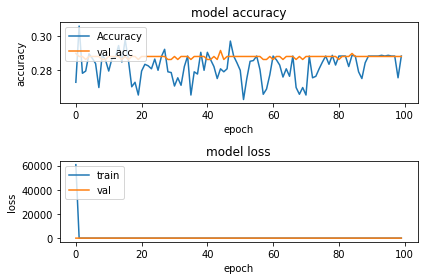

In [48]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()